<h1 style="text-align: center; font-weight: bold;">Amirali Rahimi 810100146</h1>
<h1 style="text-align: center;">CA3 - Hidden Markov Model</h1>

### Problem Description
In this project, we are going to use Hidden Morkov Model for classification of musics. We first train our model and after that we analize our trained model performance based on these standards:
- `Accuracy`
- `Precision`
- `Recall`
- `F1 Score`

In [407]:
import numpy as np
import librosa
from pathlib import Path
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
from hmmlearn import hmm
from scipy.stats import multivariate_normal
import python_speech_features as psf
from scipy.io import wavfile
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
import itertools

In [408]:
@dataclass
class HyperParams:
    partitionInSec:int
    sampleRate:int
    trainDataPercentage:float
    mfccNumber:int

In [409]:
hyperParams = HyperParams(
    partitionInSec=10,
    sampleRate=22000,
    trainDataPercentage=0.8, #percentage
    mfccNumber=13
)

## Preprocess on Samples and Extracting Features:

<a name='1-0'></a>
### Question 1:

#### Why samples should have equal length?
- `Batch Processing`: Many machine learning frameworks are optimized for batch processing. For these tools to `work effectively`, they `often` require that each sequence in the `batch be of the same length`.

- `Feature Extraction`: When using HMMs are usually converted into `feature vectors`. `If` the methodology for extracting features `assumes fixed-length inputs`, you'll require to have sequences with equal lengths.

- `Simplification`: In `implementations` of algorithms for `training HMMs`, having equal-length sequences can `simplify` the code and reduce the computational cost.

- `Alignment and Comparison`: For some applications, notably in bioinformatics or time series analysis, it might be `necessary` for sequences to have comparable lengths for `alignment` or for certain types of analysis that require equal-length sequences.



Here we are breaking songs to `equal smaller lengths` and extracting `MFCC Coefficents` from each of them. And finally visualizing the MFCC Coefficents in a heatmap.

In [410]:
def breakSong(hyperParams:HyperParams, song):
    partitionLength = hyperParams.partitionInSec * hyperParams.sampleRate
    parts = []

    for i in range(0, len(song), partitionLength):
        if(not (i + partitionLength >= len(song))):
            part = song[i:i + partitionLength]
            parts.append(part)
    return parts

In [411]:
def visualizeMfcc(mfcc, genre):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC for {genre} Genre')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.yticks(ticks=np.arange(-0.5, mfcc.shape[0] - 0.5, 1),
            labels=np.arange(0, mfcc.shape[0], 1))
    plt.tight_layout()
    plt.show()

In [412]:
genres = ["blues", "hiphop", "metal", "pop"]
songs = {genre : [] for genre in genres}
for genre in genres:
    genreFolder = Path(f"{Path().absolute()}/data/{genre}")
    songsPath = genreFolder.glob('*')
    for songPath in songsPath:
        song , sr = librosa.load(songPath, sr=hyperParams.sampleRate)
        brokeSong = breakSong(hyperParams, song)
        songs[genre].extend(brokeSong)

mfccValues = {genre : [] for genre in genres}
for genre in genres:
    for song in songs[genre]:
        mfcc = librosa.feature.mfcc(y=song, sr=hyperParams.sampleRate, n_mfcc=hyperParams.mfccNumber)
        transposeMfcc = mfcc.T
        # transposeMfcc /= np.amax(transposeMfcc)
        mfccValues[genre].append(transposeMfcc)

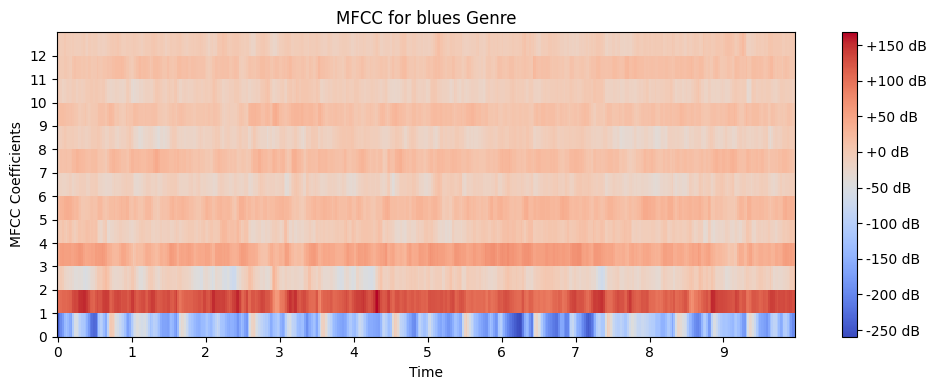

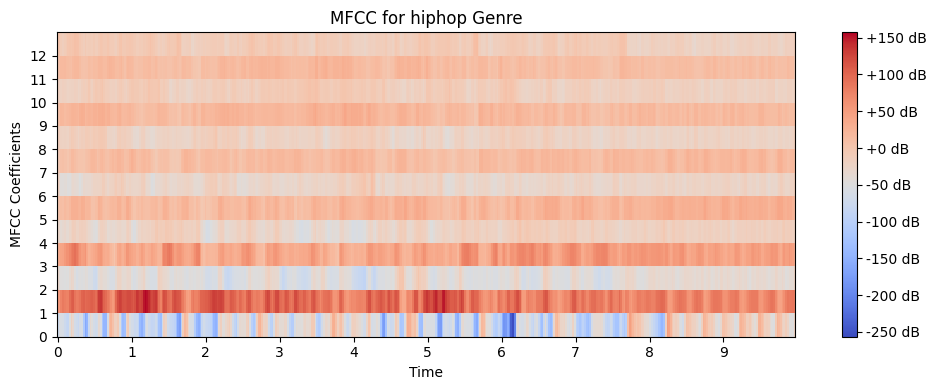

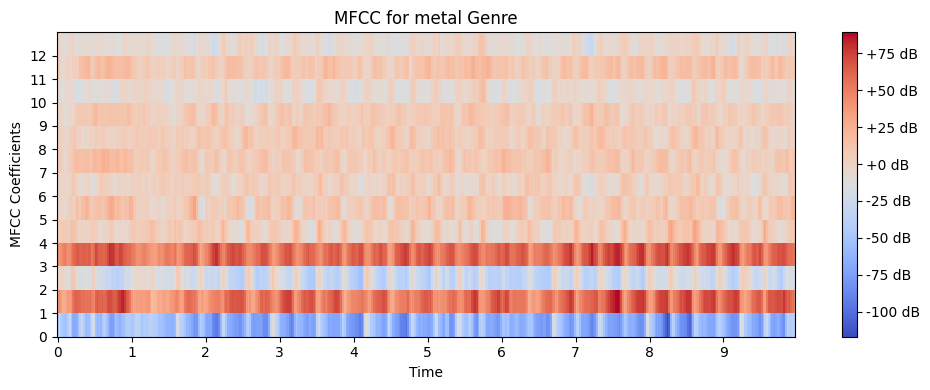

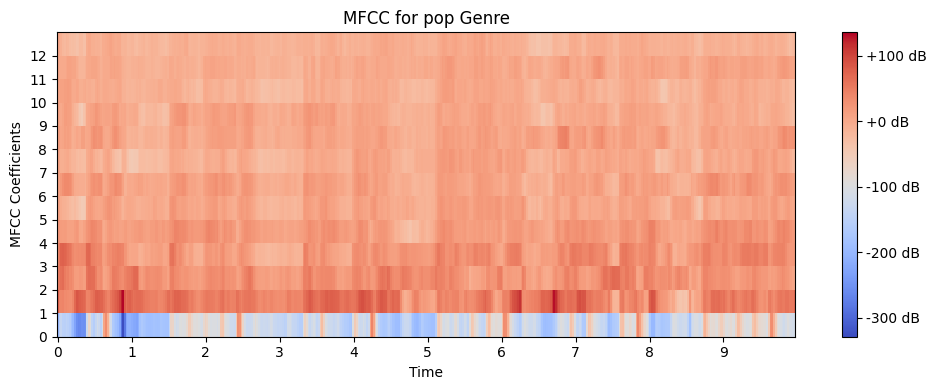

In [413]:
for genre in genres:
    visualizeMfcc(mfccValues[genre][0].T, genre)

In [414]:
trainSongs = {genre : [] for genre in genres}
mfccValuesTrainSongs = {genre : [] for genre in genres}
testSongs = {genre : [] for genre in genres}
mfccValuesTestSongs = {genre : [] for genre in genres}
for genre in genres:
    index = round(hyperParams.trainDataPercentage * len(mfccValues[genre]))
    trainSongs[genre] = songs[genre][0:index].copy()
    mfccValuesTrainSongs[genre] = mfccValues[genre][0:index].copy()
    testSongs[genre] = songs[genre][index+1:len(songs[genre])-1].copy()
    mfccValuesTestSongs[genre] = mfccValues[genre][index+1:len(mfccValues[genre])-1].copy()

<a name='1-0'></a>
### Question 2:

#### Why the frames used in the MFCC calculation overlap with each other?


- `Temporal Continuity`: Speech is a `continuous signal`. Overlapping frames `ensure` that these dependencies are captured.

- `Smoother Spectral Features`: By having overlap, the `spectral content between adjacent frames is more correlated`, which leads to smoother spectral feature transitions.

- `Reduction of Edge Effects`: Overlapping frames ensure that the `information at the edges isn’t lost`.

- `Increased Resolution`: Overlapping frames allow for a `higher time resolution` of feature extraction.

- `Stability in Noisy Environments`: Overlapping frames can improve the `robustness` of `feature extraction` in noisy environments by averaging out some of the effects of noise across overlapping sections of the signal.

<a name='1-0'></a>
### Question 3:

#### Why are only 12 or 13 basic MFCC coefficients used in most audio-related projects?
The `first 13 coefficients` of MFCCs are used because they capture the `most important information` about the spectral envelope of the audio signal The first coefficient represents the `overall energy` of the signal, while the remaining 12 coefficients capture the `spectral shape` of the signal.

## Getting Familiar to HMM:

<a name='1-0'></a>
### Question 1:

#### Explain what is meant by States and Observation? In this exercise, what are the States and How is observation obtained?
- `States`: States in HMM, means our hidden states, which our `goal is to predict in which hidden state we are` based of the observations we saw until now.
- `Observation`: Observations in HMM, `means our evidences`, which are our noisy observatin from the world and we only get to see those in our HMM.    
- In this problem, our states `could be different genres` of music which in that case we would only train 1 model for all of the musics. But our implementation is a bit different a states `doesn't refer to anything` and is meaningless(we consider the number of states as an hyperparameter), `thus we train 4 models for different genres`.
And `our observations is the MFCC coefficents` that we extracted from the songs.

<a name='1-0'></a>
### Question 2:

#### Different classes of HMM Models:
A First-Order HMM is named as such because the model assumes the Markov property of first order that is:
$$ P(S_t | S_{t-1}, S_{t-2}, …, S_1) = P(S_t|S_{t-1})$$ 
This means the future state depends only on the current state and not on any of the states prior to it.    
Features of First-Order HMM:    
- `Memoryless Transitions`: Each state transition only has a memory of the immediately previous state.
- `Simplicity`: The model is relatively simple and computationally less complex, making it efficient for many applications.
- `Stationarity`: It often assumes stationary transition probabilities (the transition probability matrix is constant over time).
Other different classes of HMM Models:
1. `Second-Order HMM`: The probability of the current state would depend on the two immediately preceding states:
$$ P(S_t | S_{t-1}, S_{t-2}, …, S_1) = P(S_t|S_{t-1}, S_{t-2})$$ 
2. `Third-Order HMM`:The probability of the current state would depend on the three immediately preceding states:
$$ P(S_t | S_{t-1}, S_{t-2}, …, S_1) = P(S_t|S_{t-1}, S_{t-2}, S_{t-3})$$ 

<a name='1-0'></a>
### Question 3:

#### Explain what phenomena is HMM suitale to model?
HMMs are useful when we are working with sequential data. They are good at finding the relations between these events and can figure out how things change over time.
HMMs are especially helpful when the data we have is noisy. As the HMMs are designed to be, they can handle this kind of datas and make reasonable predictions(these datas are our observations). Examples of phenomena we can model them with HMM:

1. `Speech Recognition`: HMMs have been very useful in speech recognition systems, as speech can be modeled as a time series of sound waves.
2. `Weather Forecasting`: HMMs can model weather sequences where states represent specific weather conditions and the observations might be related atmospheric measurements like temperature, humidity, or wind speed.

<a name='1-0'></a>
### Question 4:

#### Advantages and Disadvantages of HMMs:
- `Advantages of HMM`:
  1. *Sequence Modelling*: HMMs effectively model sequences with temporal dependencies, capturing the sequential nature of data such as speech or biological sequences.

  2. *Handling Uncertainty*: They provide a probabilistic framework which accounts for uncertainties in the observable data, as well as the state transitions.

  3. *Hidden States*: HMMs are particularly useful when the system you’re trying to model has underlying states that are not directly observable from the data.

  4. *Training Algorithms*: There are well-established algorithms for training HMMs, such as the Forward-Backward algorithm for evaluating the probability of an observation sequence, the Viterbi algorithm for uncovering the most likely sequence of hidden states, and the Baum-Welch algorithm for estimating the model parameters

  5. *Flexibility*: HMMs can be adapted to different domains and types of input data, making them versatile. The transition and emission probabilities can be adjusted to fit various scenarios

- `Disdvantages of HMM`:
  

  1. *Assumption of Markov Property*: One of the primary limitations is that the future state only depends on the current state. This can be overly simplistic for complex systems where future states may be influenced by longer historical contexts.

  2. *Assumption of Evidence Independence*: HMMs assume that the evidences are independent given the state. This assumption may not always be valid in real-world scenarios where there could be dependencies among observations.

  3. *Scalability and Complexity*: The number of parameters grows quickly with the number of states, which can make the model complex and hard to train, especially with limited data.

  4. *Local Optimum*: The training algorithms for HMMs, like Baum-Welch, can get stuck in local optima, making the choice of initial parameters crucial.



<a name='1-0'></a>
### Question 5:

#### Different types of HMM:
1. `Discrete HMMs`
2. Continuous HMMs
3. `Gaussian Mixture Model HMMs`
4. Hierarchical HMMs
5. `Autoregressive HMMs`
6. Factorial HMMs
7. `Coupled HMMs`
8. Explicit-Duration HMMs
9. `Input-Output HMMs`
10. Profile HMMs

- **`Discrete HMMs`**: These are the standard form of HMMs where the observation sequence is made up of discrete symbols. They are commonly used for problems like part-of-speech tagging or speech recognition at the phoneme level.

- **`Continuous HMMs`**`: In these models, the observations are continuous distributions, often Gaussian. Continuous HMMs are used in applications where the data are real-valued, such as in econometrics or speech processing for modeling spectral coefficients.

- **`Gaussian Mixture Model HMMs`**: These HMMs use a mixture of Gaussian distributions to model the observation probabilities. They are particularly useful in speech and audio processing where a single Gaussian distribution is not sufficient to model the complex variations in feature vectors.

## Implementing from HMMLEARN library

In [415]:
concatedMfccs = {genre : [] for genre in genres}

for genre in genres:
    concatedMfccs[genre] = np.concatenate(mfccValuesTrainSongs[genre])
    

hmm_models={}
for genre in genres:
    model = hmm.GaussianHMM(n_components=4, covariance_type="diag")
    model.fit(concatedMfccs[genre])
    hmm_models[genre] = model

libraryPredictions = {genre : [] for genre in genres}

for genre in genres:
    for mfcc in mfccValuesTestSongs[genre]:
        scores = {}
        # mfcc /= np.amax(mfcc)
        for modelGenre in genres:
            scores[modelGenre] = hmm_models[modelGenre].score(mfcc)
        maxGenre = max(scores, key=scores.get)
        libraryPredictions[genre].append(maxGenre)

## Implementing from Scratch

In [416]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = self.initial_prob[:, t] * observation_matrix[:, t]
            else:
                for j in range(self.num_hidden_states):
                    alpha[j, t] = np.sum(alpha[:, t-1] * self.transition_matrix[:, j]) * observation_matrix[j, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            for i in range(self.num_hidden_states):
                beta[i, t] = np.sum(self.transition_matrix[i, :] * observation_matrix[:, t+1] * beta[:, t+1])
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / (np.sum(x + (x == 0)))

    def _stochasticize(self, x):
        return (x + (x == 0)) / (np.sum(x + (x == 0), axis=1))

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
            for i in range(self.num_hidden_states):
                for j in range(self.num_hidden_states):
                    partial_sum[i, j] = alpha[i, t] * self.transition_matrix[i, j] * B[j, t+1] * beta[j, t+1]
            xi_sum += self._normalize(partial_sum)
            
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, T-1] * beta[:, T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum / np.sum(gamma, axis=1))
        
        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [417]:
for genre in genres:
    for mfccvalue in mfccValuesTrainSongs[genre]:
        mfccvalue /= np.amax(mfccvalue)
    concatedMfccs[genre] = np.concatenate(mfccValuesTrainSongs[genre])

In [418]:
scratchModels={}

for genre in genres:
    model = HMM(num_hidden_states=4)
    model.train(concatedMfccs[genre].T, num_iterations=2)
    scratchModels[genre] = model

scratchPredictions = {genre : [] for genre in genres}

for genre in genres:
    for mfcc in mfccValuesTestSongs[genre]:
        scores = {}
        mfcc /= np.amax(mfcc)
        for modelGenre in genres:
            scores[modelGenre] = scratchModels[modelGenre].score(mfcc.T)
        maxGenre = max(scores, key=scores.get)
        scratchPredictions[genre].append(maxGenre)

C:\Users\rog\AppData\Local\Temp\ipykernel_22852\3076544740.py:25: RuntimeWarning: invalid value encountered in divide
  alpha[:, t] /= alpha_sum
C:\Users\rog\AppData\Local\Temp\ipykernel_22852\3076544740.py:26: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(alpha_sum)
C:\Users\rog\AppData\Local\Temp\ipykernel_22852\3076544740.py:39: RuntimeWarning: invalid value encountered in divide
  beta[:, t] /= np.sum(beta[:, t])


## Analizing the Results:

In [419]:
def calculateAccuracy(predList):
    accuracy = {}
    for genre in genres:
        counter = 0
        for pred in predList[genre]:
            if pred == genre:
                counter = counter + 1
        accuracy[genre] = counter / len(predList[genre])
    return accuracy

In [420]:
def calculatePrecision(predList):
    true_positives = {genre: 0 for genre in genres}
    all_predicted = {genre: 0 for genre in genres}

    for true_genre in genres:
        for predicted_genre in predList[true_genre]:
            all_predicted[predicted_genre] += 1

            if predicted_genre == true_genre:
                true_positives[true_genre] += 1
                
    precision = {}
    for genre in genres:
        if all_predicted[genre] > 0:
            precision[genre] = true_positives[genre] / all_predicted[genre]
        else:
            precision[genre] = 0

    return precision

In [421]:
def calculateRecall(predList):
    true_positives = {genre: 0 for genre in genres}
    false_negatives = {genre: 0 for genre in genres}

    for true_genre in genres:
        for predicted_genre in predList[true_genre]:
            if predicted_genre == true_genre:
                true_positives[true_genre] += 1

    for true_genre in genres:
        for predicted_genre in predList[true_genre]:
            if predicted_genre != true_genre:
                false_negatives[true_genre] += 1

    recall = {}
    for genre in genres:
        total_actual = true_positives[genre] + false_negatives[genre]
        if total_actual > 0:
            recall[genre] = true_positives[genre] / total_actual
        else:
            recall[genre] = 0

    return recall


In [422]:
def calculateF1Scores(predList):
    precision = calculatePrecision(predList)
    recall = calculateRecall(predList)
    f1_scores = {}
    
    for genre in genres:
        p = precision[genre]
        r = recall[genre]
        if (p + r) > 0:
            f1_scores[genre] = 2 * (p * r) / (p + r)
        else:
            f1_scores[genre] = 0
    
    return f1_scores


In [423]:
def calculateAverageAccuracy(predList, average='macro'):
    correct_predictions = 0
    total_predictions = 0
    class_accuracies = []
    for genre in genres:
        class_correct = sum(1 for prediction in predList[genre] if prediction == genre)
        correct_predictions += class_correct
        total_predictions += len(predList[genre])
        class_accuracies.append(class_correct / len(predList[genre]))
    if average == 'macro':
        return sum(class_accuracies) / len(class_accuracies)
    elif average == 'micro':
        return correct_predictions / total_predictions
    elif average == 'weighted':
        weighted_sum = sum(
            (acc * len(predList[genre]) / total_predictions) for genre, acc in zip(genres, class_accuracies)
        )
        return weighted_sum


In [424]:
def calculateAveragePrecision(predList, average='macro'):
    true_positives = {genre: 0 for genre in genres}
    all_predicted = {genre: 0 for genre in genres}
    for true_genre in genres:
        for predicted_genre in predList[true_genre]:
            all_predicted[predicted_genre] += 1
            if predicted_genre == true_genre:
                true_positives[true_genre] += 1

    if average == 'macro':
        precision_per_class = [true_positives[genre] / all_predicted[genre] if all_predicted[genre] > 0 else 0 for genre in genres]
        return sum(precision_per_class) / len(precision_per_class)
    elif average == 'micro':
        micro_true_positives = sum(true_positives.values())
        micro_all_predicted = sum(all_predicted.values())
        return micro_true_positives / micro_all_predicted if micro_all_predicted > 0 else 0
    elif average == 'weighted':
        total_instances = sum(len(predList[genre]) for genre in genres)
        weighted_precision_sum = sum(
            (true_positives[genre] / all_predicted[genre] if all_predicted[genre] > 0 else 0) * (len(predList[genre]) / total_instances) for genre in genres
        )
        return weighted_precision_sum


In [425]:
def calculateAverageRecall(predList, average='macro'):
    true_positives = {genre: 0 for genre in genres}
    false_negatives = {genre: 0 for genre in genres}

    for true_genre in genres:
        for predicted_genre in predList[true_genre]:
            if predicted_genre == true_genre:
                true_positives[true_genre] += 1
            else:
                false_negatives[true_genre] += 1

    if average == 'macro':
        recall_per_class = [true_positives[genre] / (true_positives[genre] + false_negatives[genre]) if (true_positives[genre] + false_negatives[genre]) > 0 else 0 for genre in genres]
        return sum(recall_per_class) / len(recall_per_class)
    elif average == 'micro':
        micro_true_positives = sum(true_positives.values())
        micro_false_negatives = sum(false_negatives.values())
        return micro_true_positives / (micro_true_positives + micro_false_negatives) if (micro_true_positives + micro_false_negatives) > 0 else 0
    elif average == 'weighted':
        total_instances = sum((true_positives[genre] + false_negatives[genre]) for genre in genres)
        weighted_recall_sum = sum(
            (true_positives[genre] / (true_positives[genre] + false_negatives[genre]) if (true_positives[genre] + false_negatives[genre]) > 0 else 0) * ((true_positives[genre] + false_negatives[genre]) / total_instances) for genre in genres
        )
        return weighted_recall_sum


In [426]:
def calculateAverageF1Score(predList, average='macro'):
    f1_scores = calculateF1Scores(predList)
    if average == 'macro':
        macro_f1 = sum(f1_scores.values()) / len(f1_scores)
        return macro_f1
    elif average == 'micro':
        precision = calculateAveragePrecision(predList, 'micro')
        recall = calculateAverageRecall(predList, 'micro')
        micro_f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return micro_f1
    elif average == 'weighted':
        precision = calculatePrecision(predList)
        recall = calculateRecall(predList)
        total_instances = sum(len(predList[genre]) for genre in genres)
        weighted_f1_sum = sum(
            (2 * precision[genre] * recall[genre] / (precision[genre] + recall[genre]) if (precision[genre] + recall[genre]) > 0 else 0) * (len(predList[genre]) / total_instances)
            for genre in genres
        )
        return weighted_f1_sum

In [427]:
def plot_confusion_matrix(predList, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    true_labels = []
    pred_labels = []
    for genre in classes:
        true_labels.extend([genre]*len(predList[genre]))
        pred_labels.extend(predList[genre])

    cm = confusion_matrix(true_labels, pred_labels, labels=classes)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()


In [428]:
average_methods=["macro","micro","weighted"]

## Analyzing hmmlearn model

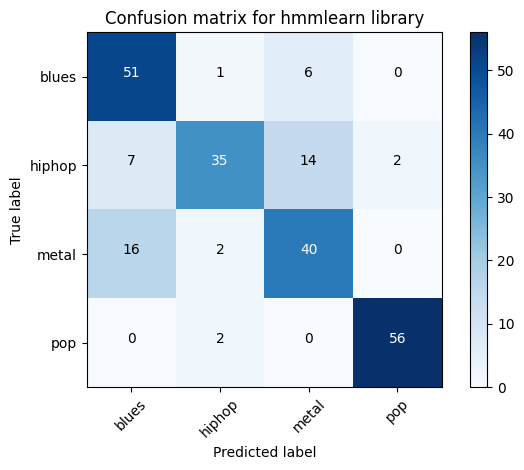

The accuracy in blues class is 0.88
The precision in blues class is 0.69
The recall in blues class is 0.88
The f1_score in blues class is 0.77
The accuracy in hiphop class is 0.60
The precision in hiphop class is 0.88
The recall in hiphop class is 0.60
The f1_score in hiphop class is 0.71
The accuracy in metal class is 0.69
The precision in metal class is 0.67
The recall in metal class is 0.69
The f1_score in metal class is 0.68
The accuracy in pop class is 0.97
The precision in pop class is 0.97
The recall in pop class is 0.97
The f1_score in pop class is 0.97
**********************************************
The accuracy in macro method is 0.78
The precision in macro method is 0.80
The recall in macro method is 0.78
The f1_score in macro method is 0.78
The accuracy in micro method is 0.78
The precision in micro method is 0.78
The recall in micro method is 0.78
The f1_score in micro method is 0.78
The accuracy in weighted method is 0.78
The precision in weighted method is 0.80
The recall

In [429]:
plot_confusion_matrix(libraryPredictions, classes=genres, title='Confusion matrix for hmmlearn library')
libraryAccuracy = calculateAccuracy(libraryPredictions)
libraryPrecision = calculatePrecision(libraryPredictions)
libraryRecall = calculateRecall(libraryPredictions)
libraryF1Score = calculateF1Scores(libraryPredictions)
for genre in genres:
    print(f"The accuracy in {genre} class is {libraryAccuracy[genre]:.2f}")
    print(f"The precision in {genre} class is {libraryPrecision[genre]:.2f}")
    print(f"The recall in {genre} class is {libraryRecall[genre]:.2f}")
    print(f"The f1_score in {genre} class is {libraryF1Score[genre]:.2f}")

print("**********************************************")

for method in average_methods:
    print(f"The accuracy in {method} method is {calculateAverageAccuracy(libraryPredictions, method):.2f}")
    print(f"The precision in {method} method is {calculateAveragePrecision(libraryPredictions, method):.2f}")
    print(f"The recall in {method} method is {calculateAverageRecall(libraryPredictions, method):.2f}")
    print(f"The f1_score in {method} method is {calculateAverageF1Score(libraryPredictions, method):.2f}")

## Analyzing from scratch model

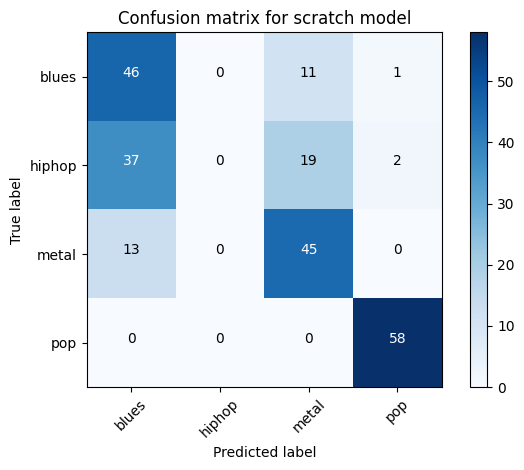

The accuracy in blues class is 0.79
The precision in blues class is 0.48
The recall in blues class is 0.79
The f1_score in blues class is 0.60
The accuracy in hiphop class is 0.00
The precision in hiphop class is 0.00
The recall in hiphop class is 0.00
The f1_score in hiphop class is 0.00
The accuracy in metal class is 0.78
The precision in metal class is 0.60
The recall in metal class is 0.78
The f1_score in metal class is 0.68
The accuracy in pop class is 1.00
The precision in pop class is 0.95
The recall in pop class is 1.00
The f1_score in pop class is 0.97
**********************************************
The accuracy in macro method is 0.64
The precision in macro method is 0.51
The recall in macro method is 0.64
The f1_score in macro method is 0.56
The accuracy in micro method is 0.64
The precision in micro method is 0.64
The recall in micro method is 0.64
The f1_score in micro method is 0.64
The accuracy in weighted method is 0.64
The precision in weighted method is 0.51
The recall

In [430]:
plot_confusion_matrix(scratchPredictions, classes=genres, title='Confusion matrix for scratch model')
scratchAccuracy = calculateAccuracy(scratchPredictions)
scratchPrecision = calculatePrecision(scratchPredictions)
scratchRecall = calculateRecall(scratchPredictions)
scratchF1Score = calculateF1Scores(scratchPredictions)
for genre in genres:
    print(f"The accuracy in {genre} class is {scratchAccuracy[genre]:.2f}")
    print(f"The precision in {genre} class is {scratchPrecision[genre]:.2f}")
    print(f"The recall in {genre} class is {scratchRecall[genre]:.2f}")
    print(f"The f1_score in {genre} class is {scratchF1Score[genre]:.2f}")

print("**********************************************")

for method in average_methods:
    print(f"The accuracy in {method} method is {calculateAverageAccuracy(scratchPredictions, method):.2f}")
    print(f"The precision in {method} method is {calculateAveragePrecision(scratchPredictions, method):.2f}")
    print(f"The recall in {method} method is {calculateAverageRecall(scratchPredictions, method):.2f}")
    print(f"The f1_score in {method} method is {calculateAverageF1Score(scratchPredictions, method):.2f}")

<a name='1-0'></a>
### Question 1:

#### How every criterion analizes the model?
- `Accuracy:` It measures the overall correctness of the model predictions. It is calculated as the ratio of the number of correct predictions to the total number of data. It can be misleading when there is an imbalanced dataset:
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
- `Precision:` It Quantifies the percentage of positive identifications by the model that are indeed accurate and valid. It is determined by the fraction of true positives relative to the aggregate of true positives and false positives. Precision is particularly valuable in scenarios where the consequences of false positives are substantial.
$$Perscision = \frac{TP}{TP + FP}$$
- `Recall:` Recall assesses the ability of a model to correctly capture all actual instances of a particular class; it’s the fraction of true positives out of the total actual positives, measuring how often the model misses true cases. In the context of HMMs, it reflects the model’s accuracy in identifying the correct sequence of states.
$$Recall = \frac{TP}{TP + FN}$$
- `F1 Score:` The F1 score harmonizes precision and recall into a single metric by taking their harmonic mean; it gives a balance between a model’s ability to accurately label true positives without wrongly labeling negatives. It is especially useful when seeking an equilibrium between the precision and recall performance of a classifier.
$$Recall = \frac{2 * Percision * Recall}{Percision + Recall}$$

<a name='1-0'></a>
### Question 2:

#### Difference of Percision and Recall and why they aren't suffiecent to evaluate the model?
Recall measures how well the model identifies the `true positive datas`, but Precision shows the `ratio of predicted positive instances that are actually correct`. So it is important to use both Recall and Precision together because they give us complementary information.
- `High Recall, Poor Model Performance`:
For instance, in a disease screening where the model is set to label every test as “disease present” it will have a recall of 100%, because it catches every actual disease case. However, this model is impractical because it also flags all healthy individuals incorrectly as sick, resulting in unnecessary anxiety and additional medical tests.
- `High Precision, Poor Model Performance`:
Conversely, if a model is designed to identify only one type of very specific, easily recognizable spam email with a particular phrase, it may do so with 100% precision. However, it would perform poorly in practice because it’s likely to miss a large number of spam emails that don’t contain that specific phrase, therefore demonstrating low recall.

<a name='1-0'></a>
### Question 3:

#### What kind of averaging does the 1F criterion use? What is the difference between this type of averaging and normal averaging and why is it important here?
The F1 score employs the harmonic mean, which is less sensitive to extreme values compared to the arithmetic mean, making it better suited for skewed data or when dealing with rates and ratios. This approach ensures that the F1 score accurately reflects model performance across imbalanced datasets by requiring high precision and recall simultaneously.

<a name='1-0'></a>
### Question 4:

#### What are Macro, Micro and Weighted Averaging?
- `Macro-Averaging`: In this approach, Precision and Recall are first computed separately for each class, after which the mean of these individual metrics is calculated. This ensures equitable weighting, with each class contributing equally to the final composite metric.
$$Macro\ Average\ Precision = \frac{\sum_{i=1}^{N} Precision_i}{N}$$
$$Macro\ Average\ Recall = \frac{\sum_{i=1}^{N} Recall_i}{N}$$

- `Micro-Averaging`: Here, aggregate counts of true positives, false positives, and false negatives for all the classes are considered collectively. Precision and Recall are then derived based on these collective numbers, giving equal importance to every single instance in the dataset.
$$Micro\ Average\ Precision = \frac{\sum_{i=1}^{N} TruePositives_i}{\sum_{i=1}^{N} TruePositives_i + FalsePositives_i}$$
$$Micro\ Average\ Recall = \frac{\sum_{i=1}^{N} TruePositives_i}{\sum_{i=1}^{N} TruePositives_i + FalseNegatives_i}$$

- `Weighted-Averaging`: This method is akin to Macro-Averaging but adjusts for class imbalance by weighting each class by its prevalence. Thus, classes with a larger number of instances exert more influence on the overall metric.
$$Weighted\ Average\ Precision = \frac{\sum_{i=1}^{N} (NumInstances_i \cdot Precision_i)}{\sum_{i=1}^{N} NumInstances_i}$$
$$Weighted\ Average\ Recall = \frac{\sum_{i=1}^{N} (NumInstances_i \cdot Recall_i)}{\sum_{i=1}^{N} NumInstances_i}$$

<a name='1-0'></a>
### Question 6:

#### Analyze the values obtained for the evaluation criteria:
As we can see our hmmlearn model is doing almost great job if we dont consider hiphop and the overall scores for different citeria are satisfying.
But our trained model is not doing as well as the hmmlearn library.


<a name='1-0'></a>
### Question 7:

The primary difference lies in the structural dissimilarity between the two models. One significant factor is the presence of a convergence monitor in the hmmlearn model that determines the optimal moment to terminate the program, whereas our hard-coded approach lacks this adaptive control. Additionally, due to the relatively lower efficiency of our model, we encounter limitations in applying a higher number of iterations for enhanced model training. Furthermore, it’s possible that the library model employs advanced hyperparameter optimization algorithms and superior data preprocessing methods, enabling it to learn the data more effectively, contributing to its higher accuracy.